## Import required packages

In [4]:
#Import required packages
import copy
import numpy as np
import logging as log
import pandas as pd
import openpyxl
import brightway2 as bw
import sys
import matplotlib.pyplot as plt
import os

In [9]:
#Local modules
#path to ODYM:
sys.path.insert(0, os.path.join(r"C:\Users\Joris\OneDrive - Newcastle University\Python\ODYM")) 
import ODYM_Classes as msc
import ODYM_Functions as msf
import dynamic_stock_model as dsm



#Import the battery design module from a local path
local_path =r"C:\Users\Joris\OneDrive - Newcastle University\Python\Projects\Batt_Sust_Model\batt_sust_model" #ADD PATH
sys.path.insert(1, local_path)
from battery_design import battery_design as bd
import battery_cost as bat_cost
import battery_emissions as bat_lca

#Local path to BatPaC version 5
path_batpac = r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\battery_sustainability_model\Case study\BatPaC 5.0 10Feb2022.xlsm"#ADD PATH


# log_verbosity = eval("log.INFO")
# log_filename  = 'log_file.md'
# [Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(),
#                                                      log_verbosity, log_verbosity)



# Battery manufacturing costs (example 1)

The price of the battery are determined ..

Battery manufacturing costs are calculated through both methods. 

Price vector methods for upstream materials.... 


Value added per process ($b$) is determined for each battery system.. 

## Establish foreground system
First, the material content of a single battery is obtained. The geometric design of the Volkswagen ID.3 77 kWh version as reported by<br>
[PushEVS.com](https://pushevs.com/2020/05/13/volkswagen-meb-details/):
* Vehicle type: battery electric vehicle
* usable battery energy: 94%
* Total pack energy: 82 kWh
* Electrode pair: NMC622-G
* Silicon additive anode: 0%
* Cells per module: 24
* Modules per pack: 12
* Cooling: liquid
* Modules in parallel: 2 <br>
<br>
All other parameters are BatPaC default parameters.

### Solve battery design in BatPaC

In [6]:
#Establish battery system class of specific design:
battery = bd.Battery_system ( vehicle_type='EV', electrode_pair='LFP-G (Power)', cells_per_module=24, modules_per_row=6,rows_of_modules=2, 
                             cells_in_parallel=1,silicon_anode= 0.0, pack_energy=82, available_energy=94)
#Establish parameter dictionary
parameter_dict = battery.parameter_dictionary()

#Solve battery design in BatPaC returning nested dictionary with material contents and parameter values (takes between 5-10 seconds). 
#Make sure BatPaC is not open or running in the background. 
#BatPaC can run in the foreground if visible=True
result_dict = bd.solve_batpac_battery_system (batpac_path = path_batpac, parameter_dict=parameter_dict, visible=False)

# Quantify material flows in physical units

In [7]:
#Brightway2 general setup:
bw.projects.set_current('parameterised_battery_lca')
bw.bw2setup()
#Import ecoinvent 3.7.1:
if 'eidb 3.7' in bw.databases:
    pass
else:
    pathi37 = 'path to ecoinvent'
    eidb37 = bw.SingleOutputEcospold2Importer(pathi37, 'eidb 3.7')
    eidb37.apply_strategies()
    eidb37.statistics()

# df_act_functions = pd.read_excel(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Modules\2_lca_lcc_module\data\bw_activity_functions.xlsx", 
#                                  sheet_name = 'activity_functions_cut_off')

# bat_lca.import_activity_functions (df_act_functions)  


Biosphere database already present!!! No setup is needed


In [13]:
#Convert BatPaC output to Brightway parameter names
result_dict['design_parameters'] = bat_lca.output_as_bw_param(result_dict)

# Append additional project parameters and recalculate project parameters (e.g. total anode active material based on process yield)
result_dict['design_parameters'] = bat_lca.get_project_parameters_dict(result_dict)

In [16]:
#Reset 
bat_lca.update_param_battery_bw(result_dict['design_parameters'])

# Cut off the exchanges if activity if present in the 'cut off database'. E.g. 6um copper foil production is present in the 'cut of database' and will be cut in the anode coating process. All cut-off exchanges are set to zero
a = bat_lca.modules_with_cuts('cut_off_materials')

# Divide all battery production activities by total battery system weight:

bat_product_act = [act['name'] for act in bw.Database('battery_production')]
for act in bat_product_act:
    pack_weight = result_dict['design_parameters']['battery_pack']
    a[act]['amount'] = a[act]['amount']
    for exc in a[act]['cuts'].keys():
        a[act]['cuts'][exc][1] = a[act]['cuts'][exc][1]
#Cut modules:
bat_lca.cut_modules_to_zero(a)

# Establish product-module dataframe of base system
A=bat_lca.modular_technology_matrix(a)

In [164]:
F = bat_cost.factors_battery_production(result_dict, baseline_parameters_path)
# actor cost UK, from Duffner et al (land ($/m2), labour ($/hr), capital ($)):
factor_cost          = np.array([2427, 24.75, 1])

# factor_cost = ParameterDict['3_PR_factor_price'].Values[:,4]
result_dict['design_parameters']['battery_manufacturing_capacity'] = 100000
F = bat_cost.factors_battery_production(result_dict, baseline_parameters_path, return_aggregated=True)
F

factor_cost_overhead = list(bat_cost.factor_overhead_multiplier (100000).values())
B = (F.T*(factor_cost*factor_cost_overhead))
B.sum().astype(int)/100000
b = B.T.sum(axis=0)/100000
C = bat_cost.material_cost_matrix (A, df_pr_material_mass, df_pr_material_unit, material_category,baseline_parameters_path, result_dict)
C_all = internal_material_cost(internal_materials, materials, A, C, b)

#Inverse the A' matrix:
A_inv = pd.DataFrame(np.linalg.pinv(A.values), A.columns, A.index)

#Establish final product demand vector for 1 battery based on pack weight
y = pd.Series(data = 0, index=A.index)
y.loc['battery pack'] = pack_weight 

#Calculate scaling vector:
s = A_inv.dot(y)


C_all.dot(s).sum()/82

pack terminals
module electronics


89.81933423209111

In [170]:
C_all.loc[:,'mixing cathode materials'].sort_values()

cathode active material (LFP)       -1391.039306
cathode binder (PVDF)                 -37.981110
cathode carbon black                  -14.392842
binder solvent (NMP)                   -2.868973
aluminium, wrought alloy                0.000000
                                        ...     
busbar                                  0.000000
anode current collector Cu (10um)       0.000000
coated separator (5um+2um)              0.000000
coolant                                 0.000000
cathode slurry                       2190.915665
Name: mixing cathode materials, Length: 93, dtype: float64

In [162]:
C_all.loc[:,IndexTable.loc['Production_processes','Classification'].Items].to_excel(r'C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\notebooks\Data\delete.xlsx')

# Calculate the value added per process ($\pi$) 

The battery value added refers to the cost of the primary production factors, similar to the system cost of MFCA. The value added ($v$) per process is based on the rectangular choice-of-technology model (RCOT) by Duchin and Levine (2011) and the LCA extension by Katelhon et al 2016. Here value added per process is calculated with 

$$v = F'\pi$$

where $F'$ is the transpose ($'$) of the physical factor requirement matrix where rows refer to the factors and columns to the process, and $\pi$ is the price per unit factor.  <br>


## Factor requirement matrix ($F$)

Factor requirement ($F$) for all battery production process are based on the calculations of BatPaC as described in the BatPaC manual. Here factor requirements are adjusted to account for varying production volumes with the following equation:
$$F= F_b \left(\frac{P}{P_b}\right)^p$$

where $F_b$ refers to the baseline factor requirement matrix, $P$ to the modelled annual production process rate, $P_b$ to the base line process rate and $p$ is the scale factor. $F_b$, $P_b$ and $p$ are obtained from BatPaC.


In [223]:
baseline_parameters_path = r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Model\data\manufacturing_cost_parameters.xlsx"
#
result_dict['design_parameters']['battery_manufacturing_capacity'] = 100000
F = bat_cost.factors_battery_production(result_dict, baseline_parameters_path, return_aggregated=True)
F

,anode calendering,anode coating and drying,anode slitting,cathode binder solvent waste recovery,cathode calendering,cathode coating and drying,cathode slitting,cell formation,cell stacking,electrolyte filling and sealing,final electrode drying,jelly roll enclosing,mixing anode materials,mixing cathode materials,module and pack assembly,receiving and shipping,terminal welding
land,669.172258,1769.858221,334.586129,403.024420,669.172258,1769.858221,334.586129,5145.997512,2082.655802,2008.081114,803.006709,669.360371,893.767445,1023.180226,3012.121671,9415.015086,1388.437201
labour,36716.878928,45896.098660,27537.659196,12472.018040,36716.878928,45896.098660,27537.659196,115068.916127,81801.142120,70984.843305,36716.878928,31548.819247,26478.446076,29636.858492,173518.505856,270534.714287,81801.142120
capital,3.512389,19.220953,2.809911,12.090733,3.512389,19.928519,2.809911,100.167183,10.181873,13.633524,5.619822,4.544508,9.309198,10.900033,28.899763,48.651466,13.884372


## Factor cost per process 
Factor cost per unit process ($b$) is calculated based on the element-wise multiplication (Hadamard product, $\circ$) of the factor requirement matrix ($F'$) and the factor price ($\pi$):
$$b=F'\circ \pi$$

In BatPaC, additional variable overhead costs (indirect cost related to materials, labour, utilities and plant maintance) and fixed expenses are included as reported in BatPaC. 
Overhead costs are here all attributed to single processes, such that $pi$ is calculated with:
$$\pi = \pi_{cost} \pi_{overhead}$$

where $\pi_{overhead}$ is the overhead multiplier. The overhead multiplier for capital ($cap$) and land ($land$) are  calculatd with:
$$\pi_{overhead} = \frac{default_{overhead} default_{capacity}}{capacity}$$

In [224]:
# BatPaC default factor cost (land ($/m2), labour ($/hr), capital ($)):
factor_cost          = np.array([3000, 25, 1])

# factor_cost = ParameterDict['3_PR_factor_price'].Values[:,4]
result_dict['design_parameters']['battery_manufacturing_capacity'] = 100000
F = bat_cost.factors_battery_production(result_dict, baseline_parameters_path, return_aggregated=True)
F

factor_cost_overhead = list(bat_cost.factor_overhead_multiplier (100000).values())
B = (F.T*(factor_cost*factor_cost_overhead))
B.sum().astype(int)/100000


land        148.92167
labour      537.02170
capital    1200.43016
dtype: float64

## Value added per pack and per process ($v$)

In [225]:
b = B.T.sum(axis=0)/100000
b

anode calendering                         33.824957
anode coating and drying                 104.061291
anode slitting                            25.280359
cathode binder solvent waste recovery     54.541176
cathode calendering                       33.824957
cathode coating and drying               106.804101
cathode slitting                          25.280359
cell formation                           465.640825
cell stacking                             87.214480
electrolyte filling and sealing           95.204447
final electrode drying                    42.609515
jelly roll enclosing                      35.415182
mixing anode materials                    52.550777
mixing cathode materials                  60.786259
module and pack assembly                 206.843344
receiving and shipping                   358.116336
terminal welding                          98.375178
dtype: float64

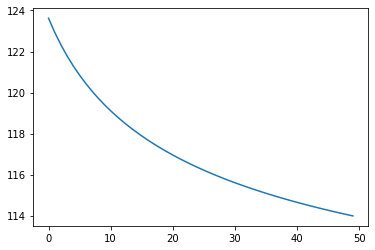

In [316]:
pack_cost_kwh = [x/60 for x in pack_cost]

plt.plot(pack_cost_kwh)

### Impact of production capacity:

Text(0.5, 1.0, 'Factor cost per battery pack by battery production capacity')

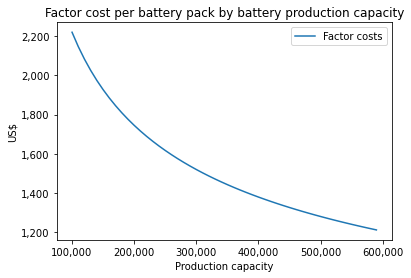

In [320]:
production = list(range(100000, 600000, 10000))
land = []
labour = []
capital = []

for x in production:
    result_dict['design_parameters']['battery_manufacturing_capacity'] = x
    F = bat_cost.factors_battery_production(result_dict, baseline_parameters_path)
    factor_cost_overhead = list(bat_cost.factor_overhead_multiplier(x).values())
    
    a = (F.T*(factor_cost*factor_cost_overhead))
    f = a.sum()/x
    land.append(f[0])
    labour.append(f[1])
    capital.append(f[2])
    
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
a = [land, labour, capital]
factor_cost_all = sum(map(np.array, a))

fig, ax = plt.subplots()
ax.plot(production, factor_cost_all,label='Factor costs')
plt.ylabel('US$')

ax.legend()
plt.xlabel('Production capacity')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
plt.title('Factor cost per battery pack by battery production capacity')

### Factor cost for different countries:

Text(0, 0.5, 'US$')

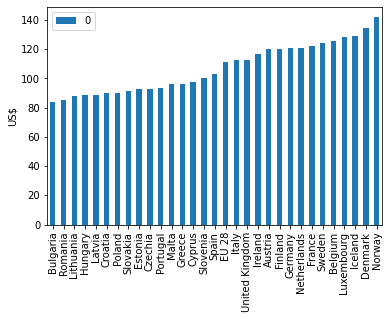

In [14]:
ParameterDict['3_PR_factor_price'].Values

production = list(range(100000, 600000, 10000))
cost_total = []

for x in range(ParameterDict['3_PR_factor_price'].Values.shape[1]):
    factor_cost = (ParameterDict['3_PR_factor_price'].Values[:,x])    
    factor_cost_overhead = list(bat_cost.factor_overhead_multiplier(100000).values())
    a = (F.T*(factor_cost*factor_cost_overhead))
    f = a.sum()/100000
    cost_total.append(f.sum())

df = pd.DataFrame(cost_total, IndexTable.loc['Regions', 'Classification'].Items,)    
    
(df.sort_values(by=0)/60).plot.bar()
plt.ylabel('US$')

# Calculate material costs
The material costs consists of a unit and mass price

$A$ = Technology matrix (material x process) <br>
$u$ = Quantity of units per pack vector <br>
$\alpha$ = Material price per kg vector <br>
$\beta$ = Material price per unit vector<br>

material cost = $A\alpha$ + $u\beta$


where $u$ is:
$$u = cost_per_unit*units/weight_total_material$$



Calculate the cost of intermediate products produced internally:

$$p_i x_i = a^p_i (\sum_{k} C_{i,k}+S_i + \sum_j p_j x_{ij})$$

$$p^l_i x^l_i = a^l_i (\sum_{k} C_{i,k}+S_i + \sum_j p_j x_{ij})$$
$a$ is here a mass-based allocation factor for process outflow:
$$1-a^l_i = x_{input}/x_{output}$$

## Calculate material costs for intermediate products ($C$)

$C$ is the material-process matrix with the price of the externally sources material. Cost of materials are calculated based on the BatPaC calculations. Material cost is therefore based on mass, units and production scaling factors (p-values).  

In [202]:
materials =  IndexTable.loc['Materials', 'Classification'].Items
technical_parameters =  IndexTable.loc['Product_design_par', 'Classification'].Items
df_pr_material_mass = pd.Series(ParameterDict['3_PR_material_price_mass'].Values, materials )
df_pr_material_unit = pd.DataFrame(ParameterDict['3_PR_material_price_unit'].Values, materials, technical_parameters)
df_pr_material_unit = df_pr_material_unit[(df_pr_material_unit!=0).any(axis=1)]




In [171]:
#Inverse the A' matrix:
A_inv = pd.DataFrame(np.linalg.pinv(A.values), A.columns, A.index)

#Establish final product demand vector for 1 battery based on pack weight
y = pd.Series(data = 0, index=A.index)
y.loc['battery pack'] = pack_weight 

#Calculate scaling vector:
s = A_inv.dot(y)

# df=m.dot(s_prime)
# df=df[df!=0]
# df.to_excel(r'C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Data\output.xlsx')

In [226]:
material_category = pd.read_excel(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Model\data\material_type_linkage.xlsx",sheet_name='values' )
C = bat_cost.material_cost_matrix (A, df_pr_material_mass, df_pr_material_unit, material_category,baseline_parameters_path, result_dict)

pack terminals
module electronics


## Allocate total costs to intermediate product and material loss

Include unit price for for intermediate products (products that remain within the production facility):

Calculate the cost of intermediate products produced internally:

$$p_i x_i = a^p_i (\sum_{k} C_{i,k}+S_i + \sum_j p_j x_{ij})$$

$$p^l_i x^l_i = a^l_i (\sum_{k} C_{i,k}+S_i + \sum_j p_j x_{ij})$$
$a$ is here a mass-based allocation factor for process outflow:
$$1-a^l_i = x_{input}/x_{output}$$

or matrix formulation:

$$P = X^{-1} ( C 1 + S )$$
